# __Traffic Volume Prediction__
<h2 align="center"><b>Advanced Data Science Capstone Poject by</b></h2>
<h2 align="center"><b>IBM / Coursera</b></h1>
<h2 align=center>Vasilis Kokkinos (September 2019)</h2>

 ## Introduction / Business Problem

USE CASE: Predictive model of traffic volume. It can be used as template for similar situations.

DATA SET: Metro Interstate Traffic Volume Data Set
Hourly Interstate 94 Westbound traffic volume for MN DoT ATR station 301, roughly midway between Minneapolis and St Paul, MN. Hourly weather features and holidays included for impacts on traffic volume.

Source: https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume



### __Attribute Information:__

__holiday:__ Categorical US National holidays plus regional holiday, Minnesota State Fair

__temp:__ Numeric Average temp in kelvin

__rain_1h:__ Numeric Amount in mm of rain that occurred in the hour

__snow_1h:__ Numeric Amount in mm of snow that occurred in the hour

__clouds_all:__ Numeric Percentage of cloud cover

__weather_main:__ Categorical Short textual description of the current weather

__weather_description:__ Categorical Longer textual description of the current weather

__date_time:__ DateTime Hour of the data collected in local CST time

__traffic_volume:__ Numeric Hourly I-94 ATR 301 reported westbound traffic volume

------------------------------------------------------------------------------------------------------

#### __Model Training__ was performed in the previous step in the notebook __traffic_volume.model_train.py.v01.ipynb__

In that step:
* The algorithms for non deep learning and deep learning models were reviewed and changed for better performance
* For non deep learning the __GBTRegressor__ model was chosen with performance __R-squared__ score __0.9982__ on the training set
* For deep learning a __Keras Sequential model__ was created with __11 Dense layers__ and perrormance __Mean Squared Error__ score around __0.0017__ on the training set
    * The __Kernel initializer VarianceScaling__ was used with __uniform__ distribution
    * The __Nadam optimizer__ was used for model compilation
The resulting alogorithms were saved and they will be used in the current notebook
    
This notebook, is the __Model Evaluation__ step where the models will be evaluated against the validation and test data sets.

--------------------------------------------------------------------------------------------

Import necessary packages, initialize Apache Spark session, and add supporting functions

In [1]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 12})

In [2]:
spark = SparkSession.builder.appName('Traffic Volume Prediction').getOrCreate()

# Create an sql context so that we can query data files in sql like syntax
sqlContext = SQLContext(spark)
spark

#### __Read in the training, validation and test data sets__

In [3]:
df_train = spark.read.parquet('traffic_volume_df_train.parquet')
df_val = spark.read.parquet('traffic_volume_df_val.parquet')
df_test = spark.read.parquet('traffic_volume_df_test.parquet')

In [4]:
df_train.createOrReplaceTempView('df_train')
df_train.printSchema()

root
 |-- temp: double (nullable = true)
 |-- rain_1h: double (nullable = true)
 |-- snow_1h: double (nullable = true)
 |-- clouds_all: integer (nullable = true)
 |-- traffic_volume: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- hour_of_day: integer (nullable = true)
 |-- holidayIndex: integer (nullable = true)
 |-- weatherMainIndex: integer (nullable = true)
 |-- weatherDescIndex: integer (nullable = true)
 |-- features: vector (nullable = true)
 |-- features_norm: vector (nullable = true)
 |-- temp_Norm: double (nullable = true)
 |-- rain_1h_Norm: double (nullable = true)
 |-- snow_1h_Norm: double (nullable = true)
 |-- clouds_all_Norm: double (nullable = true)
 |-- traffic_volume_Norm: double (nullable = true)
 |-- month_Norm: double (nullable = true)
 |-- day_of_week_Norm: double (nullable = true)
 |-- hour_of_day_Norm: double (nullable = true)
 |-- holidayIndex_Norm: double (nullable = true)
 |-- weatherMainIndex_N

In [5]:
df_val.createOrReplaceTempView('df_val')
df_val.printSchema()

root
 |-- temp: double (nullable = true)
 |-- rain_1h: double (nullable = true)
 |-- snow_1h: double (nullable = true)
 |-- clouds_all: integer (nullable = true)
 |-- traffic_volume: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- hour_of_day: integer (nullable = true)
 |-- holidayIndex: integer (nullable = true)
 |-- weatherMainIndex: integer (nullable = true)
 |-- weatherDescIndex: integer (nullable = true)
 |-- features: vector (nullable = true)
 |-- features_norm: vector (nullable = true)
 |-- temp_Norm: double (nullable = true)
 |-- rain_1h_Norm: double (nullable = true)
 |-- snow_1h_Norm: double (nullable = true)
 |-- clouds_all_Norm: double (nullable = true)
 |-- traffic_volume_Norm: double (nullable = true)
 |-- month_Norm: double (nullable = true)
 |-- day_of_week_Norm: double (nullable = true)
 |-- hour_of_day_Norm: double (nullable = true)
 |-- holidayIndex_Norm: double (nullable = true)
 |-- weatherMainIndex_N

In [6]:
df_test.createOrReplaceTempView('df_test')
df_test.printSchema()

root
 |-- temp: double (nullable = true)
 |-- rain_1h: double (nullable = true)
 |-- snow_1h: double (nullable = true)
 |-- clouds_all: integer (nullable = true)
 |-- traffic_volume: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- hour_of_day: integer (nullable = true)
 |-- holidayIndex: integer (nullable = true)
 |-- weatherMainIndex: integer (nullable = true)
 |-- weatherDescIndex: integer (nullable = true)
 |-- features: vector (nullable = true)
 |-- features_norm: vector (nullable = true)
 |-- temp_Norm: double (nullable = true)
 |-- rain_1h_Norm: double (nullable = true)
 |-- snow_1h_Norm: double (nullable = true)
 |-- clouds_all_Norm: double (nullable = true)
 |-- traffic_volume_Norm: double (nullable = true)
 |-- month_Norm: double (nullable = true)
 |-- day_of_week_Norm: double (nullable = true)
 |-- hour_of_day_Norm: double (nullable = true)
 |-- holidayIndex_Norm: double (nullable = true)
 |-- weatherMainIndex_N

## Basic data set checks
For each initial column of the training data frame (and the ones that will be used in this step), there is a corresponding normalized column with the suffix __'_NORM'__

A vector column __'features_norm'__ will be used for the non deep learning algorithm. All other independent features will be used for the deep learning algorithm

In [7]:
df_train.show(1, truncate=False)

+------+-------+-------+----------+--------------+-----+-----------+-----------+------------+----------------+----------------+---------------------------------------------+-------------------------------------------------------------------------+---------+------------+------------+---------------+-------------------+----------+----------------+----------------+-----------------+---------------------+---------------------+
|temp  |rain_1h|snow_1h|clouds_all|traffic_volume|month|day_of_week|hour_of_day|holidayIndex|weatherMainIndex|weatherDescIndex|features                                     |features_norm                                                            |temp_Norm|rain_1h_Norm|snow_1h_Norm|clouds_all_Norm|traffic_volume_Norm|month_Norm|day_of_week_Norm|hour_of_day_Norm|holidayIndex_Norm|weatherMainIndex_Norm|weatherDescIndex_Norm|
+------+-------+-------+----------+--------------+-----+-----------+-----------+------------+----------------+----------------+-------------------

In [8]:
df_val.show(1, truncate=False)

+------+-------+-------+----------+--------------+-----+-----------+-----------+------------+----------------+----------------+---------------------------------------------+--------------------------------------------------------------------------------------------------------------------------+---------+------------+------------+---------------+-------------------+----------+----------------+----------------+-----------------+---------------------+---------------------+
|temp  |rain_1h|snow_1h|clouds_all|traffic_volume|month|day_of_week|hour_of_day|holidayIndex|weatherMainIndex|weatherDescIndex|features                                     |features_norm                                                                                                             |temp_Norm|rain_1h_Norm|snow_1h_Norm|clouds_all_Norm|traffic_volume_Norm|month_Norm|day_of_week_Norm|hour_of_day_Norm|holidayIndex_Norm|weatherMainIndex_Norm|weatherDescIndex_Norm|
+------+-------+-------+----------+-------------

In [9]:
df_test.show(1, truncate=False)

+------+-------+-------+----------+--------------+-----+-----------+-----------+------------+----------------+----------------+---------------------------------------------+--------------------------------------------------------------------------------------------------------------------------+---------+------------+------------+---------------+-------------------+----------+----------------+----------------+-----------------+---------------------+---------------------+
|temp  |rain_1h|snow_1h|clouds_all|traffic_volume|month|day_of_week|hour_of_day|holidayIndex|weatherMainIndex|weatherDescIndex|features                                     |features_norm                                                                                                             |temp_Norm|rain_1h_Norm|snow_1h_Norm|clouds_all_Norm|traffic_volume_Norm|month_Norm|day_of_week_Norm|hour_of_day_Norm|holidayIndex_Norm|weatherMainIndex_Norm|weatherDescIndex_Norm|
+------+-------+-------+----------+-------------

In [10]:
print('Number of rows in the training dataframe: {}'.format(df_train.count()))

Number of rows in the training dataframe: 28194


In [11]:
print('Number of rows in the validation dataframe: {}'.format(df_val.count()))

Number of rows in the validation dataframe: 8266


In [12]:
print('Number of rows in the test dataframe: {}'.format(df_test.count()))

Number of rows in the test dataframe: 4109


## __NON DEEP LEARNING MODEL EVALUATION__

Let's import the pipeline for the model

In [13]:
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

In [14]:
gbt_model_pl = Pipeline.load('gbt_model_pl.pkl')
gbt_model_pl.getStages()

[GBTRegressor_ca150846b344]

The pipeline contains only one stage, a __GBTRegressor__. Let's extract the model and check its parameters.

In [15]:
gbtRegressor = gbt_model_pl.getStages()[-1]
model_params = gbtRegressor.extractParamMap()
for param, value in model_params.items():
    print(param, '=>', value)

GBTRegressor_ca150846b344__cacheNodeIds => False
GBTRegressor_ca150846b344__checkpointInterval => 10
GBTRegressor_ca150846b344__featureSubsetStrategy => all
GBTRegressor_ca150846b344__featuresCol => features_norm
GBTRegressor_ca150846b344__impurity => variance
GBTRegressor_ca150846b344__labelCol => traffic_volume
GBTRegressor_ca150846b344__lossType => squared
GBTRegressor_ca150846b344__maxBins => 32
GBTRegressor_ca150846b344__maxDepth => 20
GBTRegressor_ca150846b344__maxIter => 20
GBTRegressor_ca150846b344__maxMemoryInMB => 256
GBTRegressor_ca150846b344__minInfoGain => 0.0
GBTRegressor_ca150846b344__minInstancesPerNode => 1
GBTRegressor_ca150846b344__predictionCol => prediction
GBTRegressor_ca150846b344__seed => -1531700132958279692
GBTRegressor_ca150846b344__stepSize => 0.1
GBTRegressor_ca150846b344__subsamplingRate => 1.0


Let's now evaluate it against the validation and testing data sets

As performance measurement, I will use __R-squared (r2)__

In [16]:
evaluator = RegressionEvaluator().setMetricName('r2').setPredictionCol("prediction").setLabelCol("traffic_volume")

Let's once more fit and validate the __GBTRegressor__ against the training data set

In [17]:
ndl_model_gbt = gbtRegressor.fit(df_train)
gbt_prediction_train = ndl_model_gbt.transform(df_train)
gbt_score_train = evaluator.evaluate(gbt_prediction_train)

print('\tR-Squared score on training data set: ', gbt_score_train)

	R-Squared score on training data set:  0.9982753867656707


#### Let's evaluate the model with the __validation__ data set

In [18]:
gbt_prediction_val = ndl_model_gbt.transform(df_val)
gbt_score_val = evaluator.evaluate(gbt_prediction_val)

print('\tR-Squared score on validation data set: {}'.format(gbt_score_val))

	R-Squared score on validation data set: 0.8812956258245708


#### And let's evaluate the model with the __test__ data set

In [19]:
gbt_prediction_test = ndl_model_gbt.transform(df_test)
gbt_score_test = evaluator.evaluate(gbt_prediction_test)

print('\tR-Squared score on testing data set: ', gbt_score_test)

	R-Squared score on testing data set:  0.8972105519305972


The __GBTRegressor__ model is __ovefitting__ the data. The evaluation scores of the validation and test data sets are not at all close the evaluation score of the training data set

Let's run a __Grid Search__ on various values of the __maxDepth__ hyperparameter. Maybe the algorithm's performance will improve against the validation and test data

In [20]:
maxDepth_list = [7, 8, 9, 10, 11, 12, 13, 14, 15, 19]

score_train_list = []
score_val_list = []
score_test_list = []

# maxDepth_arr = np.array(maxDepth_list)
# score_arr = np.array(score_list)

# Run the Grid Search
for maxDepth in maxDepth_list:
    print('\nFor maxDepth = {}:'.format(maxDepth))
    
    gbtRegressor.set(gbtRegressor.getParam('maxDepth'), maxDepth)
    ndl_model_gbt = gbtRegressor.fit(df_train)
    
    gbt_prediction_train = ndl_model_gbt.transform(df_train)
    gbt_score_train = evaluator.evaluate(gbt_prediction_train)
    score_train_list.append(gbt_score_train)
    
    gbt_prediction_val = ndl_model_gbt.transform(df_val)
    gbt_score_val = evaluator.evaluate(gbt_prediction_val)
    score_val_list.append(gbt_score_val)
    
    gbt_prediction_test = ndl_model_gbt.transform(df_test)
    gbt_score_test = evaluator.evaluate(gbt_prediction_test)
    score_test_list.append(gbt_score_test)

    print('\tR-Squared score on training data set: ', gbt_score_train)
    print('\tR-Squared score on validation data set: ', gbt_score_val)
    print('\tR-Squared score on test data set: ', gbt_score_test)
print('\n')


For maxDepth = 7:
	R-Squared score on training data set:  0.9546136611680724
	R-Squared score on validation data set:  0.9425498502760152
	R-Squared score on test data set:  0.9489827341657071

For maxDepth = 8:
	R-Squared score on training data set:  0.9602654012046449
	R-Squared score on validation data set:  0.9428650977146027
	R-Squared score on test data set:  0.9501773184406206

For maxDepth = 9:
	R-Squared score on training data set:  0.9660220878010036
	R-Squared score on validation data set:  0.9439811478586418
	R-Squared score on test data set:  0.95062736354676

For maxDepth = 10:
	R-Squared score on training data set:  0.97370330958444
	R-Squared score on validation data set:  0.9395311018605452
	R-Squared score on test data set:  0.9472147149483373

For maxDepth = 11:
	R-Squared score on training data set:  0.9787024140888737
	R-Squared score on validation data set:  0.9341464417759491
	R-Squared score on test data set:  0.9443783842869977

For maxDepth = 12:
	R-Squared s

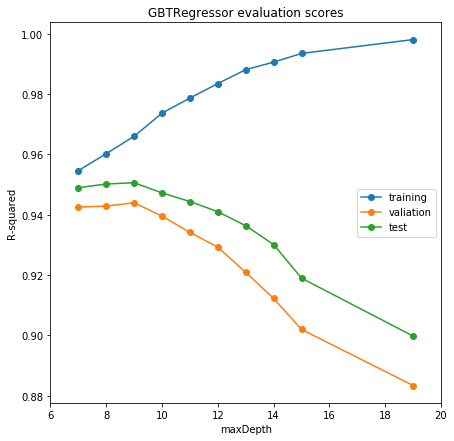

<Figure size 432x288 with 0 Axes>

In [21]:
fig = plt.figure(figsize=(7, 7))

plt.plot(maxDepth_list, score_train_list, marker='o')
plt.plot(maxDepth_list, score_val_list, marker='o')
plt.plot(maxDepth_list, score_test_list, marker='o')
ax1 = fig.add_subplot(111)
plt.title('GBTRegressor evaluation scores')
plt.ylabel('R-squared')
plt.xlabel('maxDepth')
plt.legend(['training', 'valiation', 'test'], loc='right')
plt.xlim(6, 20)
plt.show()
plt.savefig('Rsquared_gbt_evaluations.png')

With __maxDepth 9__ the optimum is reached. It is the point where the scores for the validation and test sets are at their highest

### __RandomForestRegressor__

Let's try once more the initially selected model __RandomForestRegressor__ just in case we get better results

In [22]:
from pyspark.ml.regression import RandomForestRegressor

In [23]:
rfrRegressor = RandomForestRegressor(featuresCol='features_norm', labelCol='traffic_volume', \
                                     predictionCol='prediction', maxDepth=20)

In [24]:
ndl_model_rfr = rfrRegressor.fit(df_train)
rfr_prediction_train = ndl_model_rfr.transform(df_train)
rfr_score_train = evaluator.evaluate(rfr_prediction_train)

print('\tR-Squared score on training data set: ', rfr_score_train)

	R-Squared score on training data set:  0.9801170634494042


In [25]:
rfr_prediction_val = ndl_model_rfr.transform(df_val)
rfr_score_val = evaluator.evaluate(rfr_prediction_val)

print('\tR-Squared score on validation data set: ', rfr_score_val)

	R-Squared score on validation data set:  0.9434548231875567


In [26]:
rfr_prediction_test = ndl_model_rfr.transform(df_test)
rfr_score_test = evaluator.evaluate(rfr_prediction_test)

print('\tR-Squared score on test data set: ', rfr_score_test)

	R-Squared score on test data set:  0.9504064423930006


Once more, we will run a __Grid Search__ on the __rfrRegressor__ to find out how the performance is changing on all of the data sets by increasing the maxDepth hyperparameter

In [27]:
maxDepth_list = [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]

score_train_list = []
score_val_list = []
score_test_list = []

# Run the Grid Search
for maxDepth in maxDepth_list:
    print('\nFor maxDepth = {}:'.format(maxDepth))
    
    rfrRegressor.set(rfrRegressor.getParam('maxDepth'), maxDepth)
    ndl_model_rfr = rfrRegressor.fit(df_train)
    
    rfr_prediction_train = ndl_model_rfr.transform(df_train)
    rfr_score_train = evaluator.evaluate(rfr_prediction_train)
    score_train_list.append(rfr_score_train)
    
    rfr_prediction_val = ndl_model_rfr.transform(df_val)
    rfr_score_val = evaluator.evaluate(rfr_prediction_val)
    score_val_list.append(rfr_score_val)
    
    rfr_prediction_test = ndl_model_rfr.transform(df_test)
    rfr_score_test = evaluator.evaluate(rfr_prediction_test)
    score_test_list.append(rfr_score_test)

    print('\tR-Squared score on training data set: ', rfr_score_train)
    print('\tR-Squared score on validation data set: ', rfr_score_val)
    print('\tR-Squared score on test data set: ', rfr_score_test)
print('\n')


For maxDepth = 14:
	R-Squared score on training data set:  0.9630242995842316
	R-Squared score on validation data set:  0.94091617102998
	R-Squared score on test data set:  0.9471430530342506

For maxDepth = 15:
	R-Squared score on training data set:  0.9679204430254837
	R-Squared score on validation data set:  0.9426632847639529
	R-Squared score on test data set:  0.9486546647121459

For maxDepth = 16:
	R-Squared score on training data set:  0.9721005316703398
	R-Squared score on validation data set:  0.9436070361622988
	R-Squared score on test data set:  0.9493530918035279

For maxDepth = 17:
	R-Squared score on training data set:  0.9751362201853556
	R-Squared score on validation data set:  0.9438704239902105
	R-Squared score on test data set:  0.9500043966610587

For maxDepth = 18:
	R-Squared score on training data set:  0.9774573459883079
	R-Squared score on validation data set:  0.9436108976611511
	R-Squared score on test data set:  0.9503390446660297

For maxDepth = 19:
	R-Squa

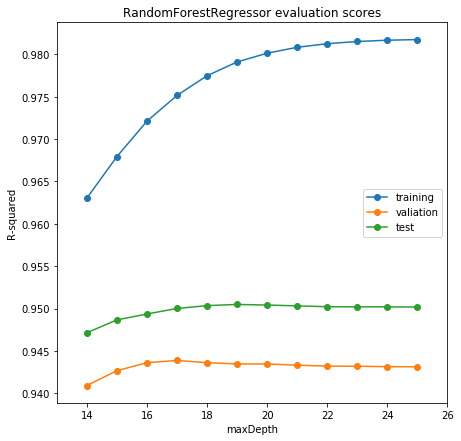

<Figure size 432x288 with 0 Axes>

In [28]:
fig = plt.figure(figsize=(7, 7))

plt.plot(maxDepth_list, score_train_list, marker='o')
plt.plot(maxDepth_list, score_val_list, marker='o')
plt.plot(maxDepth_list, score_test_list, marker='o')
ax1 = fig.add_subplot(111)
plt.title('RandomForestRegressor evaluation scores')
plt.ylabel('R-squared')
plt.xlabel('maxDepth')
plt.legend(['training', 'valiation', 'test'], loc='right')
plt.xlim(13, 26)
plt.show()
plt.savefig('Rsquared_rfr_evaluations.png')

For the RandomForestRegressor with __maxDepth 20__ the optimum is reached. It is the point where the scores for the validation and test sets are at their highest

The results are very similar to the ones of the __GBTRegressor__ for maxDepth 9

#### The __GBTRegressor with maxDepth 9__ will be chosen as our __final__ non deep learning algorithm

### NON DEEP LEARNING CROSS VALIDATION
Next, let's run cross-validation against our __GBTRegressor__ to check how it performs on different combinations of training and data set

The model will be recreated and evaluated 3 times against different groups of training and validation data sets

In [29]:
from pyspark.ml.regression import GBTRegressor

In [30]:
from sklearn.model_selection import train_test_split

Read the whole normalized data set that was saved in the __model definition task

In [31]:
df_norm = spark.read.parquet('traffic_volume_df_norm.parquet')

In [32]:
n_folds = 3

for i in range(n_folds):
    # Split data
    train, val = df_norm.randomSplit([0.7, 0.3])
    gbtRegressor = GBTRegressor(featuresCol='features_norm', labelCol='traffic_volume', \
                                predictionCol='prediction', maxDepth=9)
    ndl_model_gbt = gbtRegressor.fit(train)

    gbt_prediction_train = ndl_model_gbt.transform(train)
    gbt_score_train = evaluator.evaluate(gbt_prediction_train)

    gbt_prediction_val = ndl_model_gbt.transform(val)
    gbt_score_val = evaluator.evaluate(gbt_prediction_val)

    print('\tR-Squared score on training data set: {}'.format(gbt_score_train))
    print('\tR-Squared score on validation data set: {}\n'.format(gbt_score_val))

	R-Squared score on training data set: 0.9660144926186148
	R-Squared score on validation data set: 0.9460752078333213

	R-Squared score on training data set: 0.9656520436802297
	R-Squared score on validation data set: 0.9441421681680303

	R-Squared score on training data set: 0.9654196320577616
	R-Squared score on validation data set: 0.9482240885412011



The results of the cross-validation are __very similar__ to the evaluation metrics of our saved algorithm

#### Let's once again define, fit, the model and check the training, validation and test scores

In [33]:
gbtRegressor = GBTRegressor(featuresCol='features_norm', labelCol='traffic_volume', \
                            predictionCol='prediction', maxDepth=9)

In [34]:
ndl_model_gbt = gbtRegressor.fit(df_train)

gbt_prediction_train = ndl_model_gbt.transform(df_train)
gbt_score_train = evaluator.evaluate(gbt_prediction_train)

gbt_prediction_val = ndl_model_gbt.transform(df_val)
gbt_score_val = evaluator.evaluate(gbt_prediction_val)

gbt_prediction_test = ndl_model_gbt.transform(df_test)
gbt_score_test = evaluator.evaluate(gbt_prediction_test)

In [35]:
print('\tR-Squared score on training data set: {}'.format(gbt_score_train))
print('\tR-Squared score on validation data set: {}'.format(gbt_score_val))
print('\tR-Squared score on test data set: {}'.format(gbt_score_test))

	R-Squared score on training data set: 0.9660220878010036
	R-Squared score on validation data set: 0.9439811478586418
	R-Squared score on test data set: 0.95062736354676


#### Now, let's save our final trained model to __'trained_gbt'__ so that it is readily avaibable for use.
It can be then reloaded using __GBTRegressionModel__ from __pyspark.ml.regression__

In [36]:
ndl_model_gbt.write().overwrite().save('trained_gbt')

#### Finally, et's also see some actual results from our algorithm on all three data sets with treir corresponding actual values

In [37]:
gbt_prediction_train.select('traffic_volume', 'prediction').show(30, truncate=False)

+--------------+------------------+
|traffic_volume|prediction        |
+--------------+------------------+
|1462          |1563.670486960197 |
|1037          |1127.148247825417 |
|800           |690.7558869200066 |
|354           |320.4750578495383 |
|459           |431.319930836141  |
|1909          |1784.0818640558932|
|2689          |2591.709787085103 |
|472           |494.58909921253075|
|2384          |2399.7232285610826|
|3706          |3555.7096964948264|
|4611          |4911.869128560284 |
|4748          |4689.781293669676 |
|5071          |4441.466456782385 |
|737           |714.2430764661281 |
|2486          |2513.678334824791 |
|1070          |1119.969374382043 |
|312           |349.193846904184  |
|256           |314.691059190505  |
|4360          |4757.214634839706 |
|3504          |3161.167598348907 |
|3067          |3005.897810297645 |
|334           |334.1103630207743 |
|4453          |4670.725485815148 |
|1129          |1248.9184797360092|
|744           |774.25604771

In [38]:
gbt_prediction_val.select('traffic_volume', 'prediction').show(30, truncate=False)

+--------------+------------------+
|traffic_volume|prediction        |
+--------------+------------------+
|678           |762.9390179491469 |
|277           |279.6014873536222 |
|1319          |1289.1505944423454|
|194           |269.68270185135896|
|723           |816.1042824899738 |
|312           |321.3326885110711 |
|2238          |2536.4849513340882|
|383           |420.72746968064905|
|1430          |1188.3359888494538|
|1988          |1619.4867666679136|
|2526          |2860.221682166172 |
|3735          |4312.841609819084 |
|2213          |1798.3147243946246|
|1707          |1903.1084477970712|
|4717          |5203.3189228021   |
|2487          |2846.9531385415235|
|5332          |5741.720781774761 |
|3885          |4026.0263853366323|
|3433          |3980.905893443798 |
|683           |949.7076178650484 |
|272           |314.691059190505  |
|290           |195.052961647324  |
|2494          |1929.589025271148 |
|719           |754.3088820401828 |
|686           |3560.6916736

In [39]:
gbt_prediction_test.select('traffic_volume', 'prediction').show(30, truncate=False)

+--------------+------------------+
|traffic_volume|prediction        |
+--------------+------------------+
|417           |344.49632745607806|
|1198          |1194.6190690054461|
|2641          |2594.859547015237 |
|341           |313.51202225124445|
|3073          |3440.819069115108 |
|396           |834.9791776952057 |
|5654          |4870.642351453952 |
|2124          |930.1257658475109 |
|3046          |3379.077608784268 |
|212           |249.08436108182912|
|830           |379.09302876492586|
|4596          |3939.2094093352966|
|5032          |5086.341132449637 |
|6106          |5269.771567588829 |
|1436          |2407.621523205804 |
|585           |268.94813781373875|
|805           |2281.184926829558 |
|2643          |2722.7723210350373|
|737           |756.1527021168355 |
|3832          |3636.767306495421 |
|292           |396.6377968818442 |
|2621          |3501.710154731893 |
|1721          |1619.4867666679136|
|2067          |2251.7100985357647|
|2041          |1507.4022035

## __DEEP LEARNING MODEL EVALUATION__

#### __Keras__ is used as the Deep Learning framework

In [40]:
from keras.models import Sequential
from keras.layers import Dense

# To be used in the custom metrics function
from keras import backend as K

# For the model compilation
from keras.optimizers import Adam
from keras import metrics

Using TensorFlow backend.


First, let's load the saved Sequential model

In [41]:
from keras.models import load_model

In [42]:
model = load_model('dl_full_model.h5')
model.summary()







Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_89 (Dense)             (None, 20)                220       
_________________________________________________________________
dense_90 (Dense)             (None, 512)               10752     
_________________________________________________________________
dense_91 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_92 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_93 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_94 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_95 (Dense)             (None, 64)         

Create arrays that correspond to the training and validation data sets

In [43]:
# Create temporary dataframes
X_train = df_train['temp_Norm', 'rain_1h_Norm', 'snow_1h_Norm', 'clouds_all_Norm', 'month_Norm', 'day_of_week_Norm',
                'hour_of_day_Norm', 'holidayIndex_Norm', 'weatherMainIndex_Norm', 'weatherDescIndex_Norm']
y_train = df_train[['traffic_volume_Norm']]
X_val = df_val['temp_Norm', 'rain_1h_Norm', 'snow_1h_Norm', 'clouds_all_Norm', 'month_Norm', 'day_of_week_Norm',
                'hour_of_day_Norm', 'holidayIndex_Norm', 'weatherMainIndex_Norm', 'weatherDescIndex_Norm']
y_val = df_val[['traffic_volume_Norm']]
X_test = df_test['temp_Norm', 'rain_1h_Norm', 'snow_1h_Norm', 'clouds_all_Norm', 'month_Norm', 'day_of_week_Norm',
                'hour_of_day_Norm', 'holidayIndex_Norm', 'weatherMainIndex_Norm', 'weatherDescIndex_Norm']
y_test = df_test[['traffic_volume_Norm']]

In [44]:
# Create the corresponding arrays
X_train.createOrReplaceTempView('X_train')
X_train_arr = np.array(spark.sql('select * from X_train').collect())

y_train.createOrReplaceTempView('y_train')
y_train_arr = np.array(spark.sql('select * from y_train').collect())

X_val.createOrReplaceTempView('X_val')
X_val_arr = np.array(spark.sql('select * from X_val').collect())

y_val.createOrReplaceTempView('y_val')
y_val_arr = np.array(spark.sql('select * from y_val').collect())

X_test.createOrReplaceTempView('X_test')
X_test_arr = np.array(spark.sql('select * from X_test').collect())

y_test.createOrReplaceTempView('y_test')
y_test_arr = np.array(spark.sql('select * from y_test').collect())

#### Let's see the evaluation metrics of the model on the training set and on the validation set.

In [45]:
# Training data set
score_train = model.evaluate(X_train_arr, y_train_arr)
print('\tTraining data set evaluation Mean Squared Error: {}'.format(score_train[1]))
print('\tTraining data set evaluation Mean Absolute Error: {}'.format(score_train[2]))

28194/28194 [==============================] - 2s 63us/step
	Training data set evaluation Mean Squared Error: 0.001674305948712752
	Training data set evaluation Mean Absolute Error: 0.025758778695021065


In [46]:
# Validation data set
score_val = model.evaluate(X_val_arr, y_val_arr)
print('\tValidation data set evaluation Mean Squared Error: {}'.format(score_val[1]))
print('\tValidation data set evaluation Mean Absolute Error: {}'.format(score_val[2]))

8266/8266 [==============================] - 0s 37us/step
	Validation data set evaluation Mean Squared Error: 0.004920967968805864
	Validation data set evaluation Mean Absolute Error: 0.03944782460252165


In [47]:
# Test data set
score_test = model.evaluate(X_test_arr, y_test_arr)
print('\tTest data set evaluation Mean Squared Error: {}'.format(score_test[1]))
print('\tTest data set evaluation Mean Absolute Error: {}'.format(score_test[2]))

4109/4109 [==============================] - 0s 36us/step
	Test data set evaluation Mean Squared Error: 0.004034162629620111
	Test data set evaluation Mean Absolute Error: 0.03744746143545481


Let's now use __RSquared (r2)__ from scikit-learn to have another indication of how the model performs

We will also have comparable results to the non deep learning algorithm

In [48]:
from sklearn.metrics import r2_score

On the _training_ set

In [49]:
result = model.predict(X_train_arr)
r2Score = r2_score(y_train_arr, result)
r2Score

0.9774717092136431

On the _validation_ set

In [50]:
result = model.predict(X_val_arr)
r2Score = r2_score(y_val_arr, result)
r2Score

0.9337876428281736

And on the _test_ set

In [51]:
result = model.predict(X_test_arr)
r2Score = r2_score(y_test_arr, result)
r2Score

0.945653176405038

__The results of our deep learning algorithm are very similar to the ones of the non-deep learning one__

### __DEEP LEARNING CROSS VALIDATION__
As a final step, let's run cross-validation against our model to check how it performs on different combinations of training and validation data sets

The model will be recreated and evaluated 3 times

Create an array that correspond to the whole data set and one that corresponds to the target feature

In [52]:
X_norm = df_norm['temp_Norm', 'rain_1h_Norm', 'snow_1h_Norm', 'clouds_all_Norm', 'month_Norm', 'day_of_week_Norm',
                'hour_of_day_Norm', 'holidayIndex_Norm', 'weatherMainIndex_Norm', 'weatherDescIndex_Norm']
X_norm.createOrReplaceTempView('X_norm')
X_norm_arr = np.array(spark.sql('select * from X_norm').collect())

y_norm = df_norm[['traffic_volume_Norm']]
y_norm.createOrReplaceTempView('y_norm')
y_norm_arr = np.array(spark.sql('select * from y_norm').collect())

In [53]:
from keras.optimizers import Nadam
from keras.initializers import VarianceScaling

In [54]:
n_folds = 3
optimizer = Nadam()
kernel_initializer = VarianceScaling(distribution='uniform')

for i in range(n_folds):
    # Split data
    X_train, X_val, y_train, y_val = train_test_split(X_norm_arr, y_norm_arr, test_size=0.30, \
                                                      random_state = np.random.randint(1, 1000, 1)[0])

    # Redefine, compile and evaluate the model 
    cv_model = Sequential()
    cv_model.add(Dense(20, input_shape=(10,), kernel_initializer=kernel_initializer, \
                       activation='relu'))
    cv_model.add(Dense(512, kernel_initializer=kernel_initializer, activation='relu'))
    cv_model.add(Dense(256, kernel_initializer=kernel_initializer, activation='relu'))
    cv_model.add(Dense(128, kernel_initializer=kernel_initializer, activation='relu'))
    cv_model.add(Dense(64, kernel_initializer=kernel_initializer, activation='relu'))
    cv_model.add(Dense(32, kernel_initializer=kernel_initializer, activation='relu'))
    cv_model.add(Dense(64, kernel_initializer=kernel_initializer, activation='relu'))
    cv_model.add(Dense(16, kernel_initializer=kernel_initializer, activation='relu'))
    cv_model.add(Dense(8, kernel_initializer=kernel_initializer, activation='relu'))
    cv_model.add(Dense(4, kernel_initializer=kernel_initializer, activation='relu'))
    cv_model.add(Dense(1, kernel_initializer=kernel_initializer, activation='linear'))

    cv_model.compile(loss='mse', optimizer=optimizer, metrics=['mse', 'mae'])

    cv_model.fit(X_train, y_train, epochs=300, batch_size=127, verbose=0)
    
    score = cv_model.evaluate(X_val, y_val)
    print('mse: {} - mae: {}'.format(score[1], score[2]))
    del cv_model

12171/12171 [==============================] - 1s 47us/step
mse: 0.004702664798880263 - mae: 0.039143725183794935
12171/12171 [==============================] - 1s 55us/step
mse: 0.00486332613605372 - mae: 0.03978744272955901
12171/12171 [==============================] - 1s 65us/step
mse: 0.005078908805910066 - mae: 0.04110468275853927


Again, the results of the cross-validation on the validation data sets are __very similar__ to the evaluation metrics of our saved model

#### Let's see some actual results from our algorithm on all three data sets with treir corresponding actual values

We will use the inverse_transform function of sklearn.preprocessing.MinMaxScaler

In [55]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler as skMinMax

In [56]:
# Create a spark data frame from the actual value of traffic_volume
df_norm = spark.read.parquet('traffic_volume_df_norm.parquet')
df_norm.createOrReplaceTempView('df_norm')
y_actual_arr = np.array(spark.sql('select traffic_volume from df_norm').collect())

# Create a MinMaxScaler from sklearn.preprocessing and fit it to the actual traffic_volume
mmScaler = skMinMax()
mmScaler.fit(y_actual_arr)

MinMaxScaler(copy=True, feature_range=(0, 1))

Training data set

In [57]:
y_train_actual = df_train[['traffic_volume']]
y_train_actual.createOrReplaceTempView('y_val_actual')
y_train_actual_arr = np.array(spark.sql('select traffic_volume from y_val_actual').collect())

# Get the predictions of model on the training data set and inverse transform using the MinMaxScaler
pred_train = mmScaler.inverse_transform(model.predict(X_train_arr))

# Create a spark data frame with the actual and predicted values
train_comp_arr = np.concatenate((y_train_actual_arr, pred_train), axis=1)
train_comp_df = spark.createDataFrame(pd.DataFrame(train_comp_arr, columns=list(['actual', 'predicted'])))

# Show some values
train_comp_df.show(30, truncate=False)

+------+------------------+
|actual|predicted         |
+------+------------------+
|1462.0|1437.88818359375  |
|1037.0|962.121826171875  |
|800.0 |694.4655151367188 |
|354.0 |385.0582580566406 |
|459.0 |466.1631774902344 |
|1909.0|1787.2742919921875|
|2689.0|2636.73876953125  |
|472.0 |412.7055969238281 |
|2384.0|2318.844482421875 |
|3706.0|2365.939208984375 |
|4611.0|4802.21044921875  |
|4748.0|4701.0068359375   |
|5071.0|5076.34375        |
|737.0 |781.7797241210938 |
|2486.0|2605.551513671875 |
|1070.0|947.4486694335938 |
|312.0 |253.3040771484375 |
|256.0 |301.6612854003906 |
|4360.0|4562.03515625     |
|3504.0|3535.22265625     |
|3067.0|2792.346923828125 |
|334.0 |370.67510986328125|
|4453.0|4668.5244140625   |
|1129.0|1051.002197265625 |
|744.0 |860.716796875     |
|209.0 |260.59814453125   |
|443.0 |427.1110534667969 |
|694.0 |547.486328125     |
|754.0 |743.773681640625  |
|759.0 |659.431396484375  |
+------+------------------+
only showing top 30 rows



Validation data set

In [58]:
y_val_actual = df_val[['traffic_volume']]
y_val_actual.createOrReplaceTempView('y_val_actual')
y_val_actual_arr = np.array(spark.sql('select traffic_volume from y_val_actual').collect())

# Get the predictions of model on the valing data set and inverse transform using the MinMaxScaler
pred_val = mmScaler.inverse_transform(model.predict(X_val_arr))

# Create a spark data frame with the actual and predicted values
val_comp_arr = np.concatenate((y_val_actual_arr, pred_val), axis=1)
val_comp_df = spark.createDataFrame(pd.DataFrame(val_comp_arr, columns=list(['actual', 'predicted'])))

# Show some values
val_comp_df.show(30, truncate=False)

+------+------------------+
|actual|predicted         |
+------+------------------+
|678.0 |568.4520263671875 |
|277.0 |301.69219970703125|
|1319.0|1463.9365234375   |
|194.0 |259.5902404785156 |
|723.0 |755.0590209960938 |
|312.0 |341.1545715332031 |
|2238.0|2499.9951171875   |
|383.0 |412.2965393066406 |
|1430.0|909.1919555664062 |
|1988.0|1254.4119873046875|
|2526.0|3720.16796875     |
|3735.0|4828.93994140625  |
|2213.0|2362.77685546875  |
|1707.0|1649.9310302734375|
|4717.0|4972.2392578125   |
|2487.0|2805.4306640625   |
|5332.0|5036.85791015625  |
|3885.0|4184.6796875      |
|3433.0|3729.0234375      |
|683.0 |688.7079467773438 |
|272.0 |292.059814453125  |
|290.0 |394.8498840332031 |
|2494.0|2002.3751220703125|
|719.0 |767.3519897460938 |
|686.0 |649.4708251953125 |
|667.0 |691.5983276367188 |
|269.0 |596.1168212890625 |
|2582.0|2590.03369140625  |
|5506.0|5320.95166015625  |
|302.0 |374.4152526855469 |
+------+------------------+
only showing top 30 rows



Test data set

In [59]:
y_test_actual = df_test[['traffic_volume']]
y_test_actual.createOrReplaceTempView('y_test_actual')
y_test_actual_arr = np.array(spark.sql('select traffic_volume from y_test_actual').collect())

# Get the predictions of model on the testing data set and inverse transform using the MinMaxScaler
pred_test = mmScaler.inverse_transform(model.predict(X_test_arr))

# Create a spark data frame with the actual and predicted testues
test_comp_arr = np.concatenate((y_test_actual_arr, pred_test), axis=1)
test_comp_df = spark.createDataFrame(pd.DataFrame(test_comp_arr, columns=list(['actual', 'predicted'])))

# Show some testues
test_comp_df.show(30, truncate=False)

+------+------------------+
|actual|predicted         |
+------+------------------+
|417.0 |425.2293701171875 |
|1198.0|1014.9075317382812|
|2641.0|3479.89453125     |
|341.0 |418.23907470703125|
|3073.0|3642.2998046875   |
|396.0 |572.741455078125  |
|5654.0|5325.19091796875  |
|2124.0|392.3260192871094 |
|3046.0|3293.327392578125 |
|212.0 |241.93966674804688|
|830.0 |413.26055908203125|
|4596.0|2375.33349609375  |
|5032.0|5412.7802734375   |
|6106.0|5107.658203125    |
|1436.0|1645.2247314453125|
|585.0 |359.8426818847656 |
|805.0 |2155.146240234375 |
|2643.0|2671.373291015625 |
|737.0 |678.7713012695312 |
|3832.0|2496.06396484375  |
|292.0 |263.18658447265625|
|2621.0|2922.573486328125 |
|1721.0|1336.5950927734375|
|2067.0|2241.939208984375 |
|2041.0|1622.156005859375 |
|5554.0|5090.59326171875  |
|255.0 |288.91290283203125|
|660.0 |703.1419067382812 |
|742.0 |551.9037475585938 |
|4232.0|4996.39208984375  |
+------+------------------+
only showing top 30 rows



## __Summary__

In this __evaluation__ step the non deep learning and a deep leerning algorithm for our non-linear regression problem were evaluated. 

In the case of the non deep learning algorithm, the model was slightly changed to prevent __overfitting__ the data. In particular, __the maxDepth hyperparameter was changed to 9__

The algorithms were also cross-validated against different combinations of training and validation data sets and the results were very similar.

Also some examples of actual values and the corresponding predictions were presented